<a href="https://colab.research.google.com/github/ryan73093/kaggle-sklearn/blob/main/Predicting_Churn_for_Bank_Customers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/adammaus/predicting-churn-for-bank-customers

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import random
import warnings

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [2]:
from google.colab import drive
drive.mount('/content/drive')##出現提示欄進行授權
os.chdir('/content/drive/My Drive/Colab Notebooks/kaggle-sklearn') #切換該目錄
# os.listdir() #確認目錄內容

Mounted at /content/drive


In [3]:
df_set = pd.read_csv('data/Churn_Modelling.csv')
print(df_set.head())

   RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         790

##Encoder

In [4]:
TARGET='Exited'

# encoder
df_set=df_set.drop(columns=['Surname'])
le = LabelEncoder()
df_set['Gender']=le.fit_transform(df_set['Gender'])
df_set=pd.get_dummies(df_set)

# concat
df_feature=df_set.drop(columns=[TARGET])
df_target=df_set[TARGET]
df=pd.concat([df_feature,df_target],axis=1)
print(df.head())



   RowNumber  CustomerId  CreditScore  Gender  Age  Tenure    Balance  \
0          1    15634602          619       0   42       2       0.00   
1          2    15647311          608       0   41       1   83807.86   
2          3    15619304          502       0   42       8  159660.80   
3          4    15701354          699       0   39       1       0.00   
4          5    15737888          850       0   43       2  125510.82   

   NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0              1          1               1        101348.88   
1              1          0               1        112542.58   
2              3          1               0        113931.57   
3              2          0               0         93826.63   
4              1          1               1         79084.10   

   Geography_France  Geography_Germany  Geography_Spain  Exited  
0                 1                  0                0       1  
1                 0                  0      

## Analysis

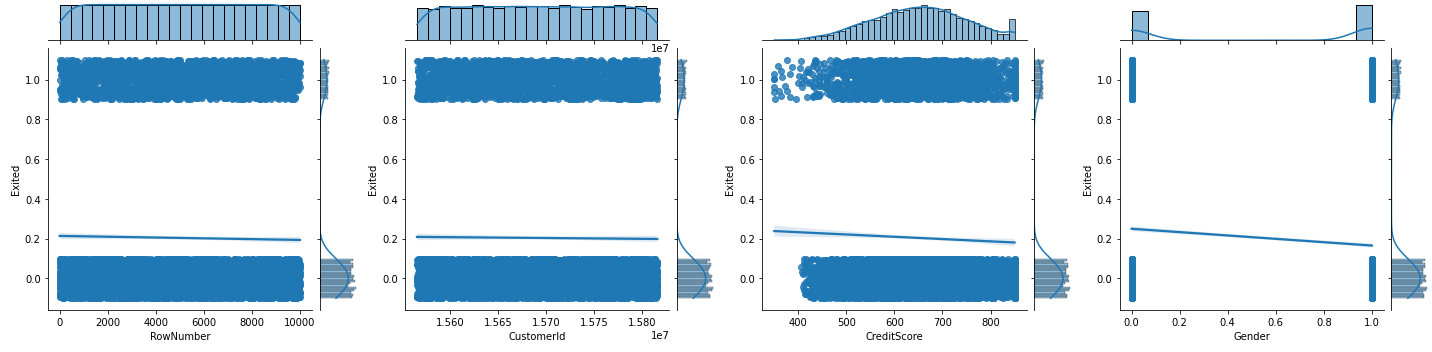

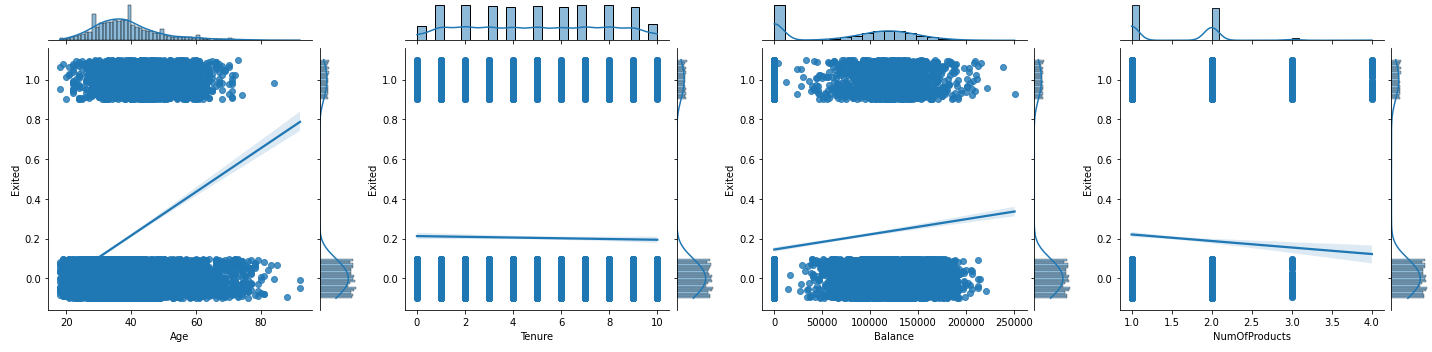

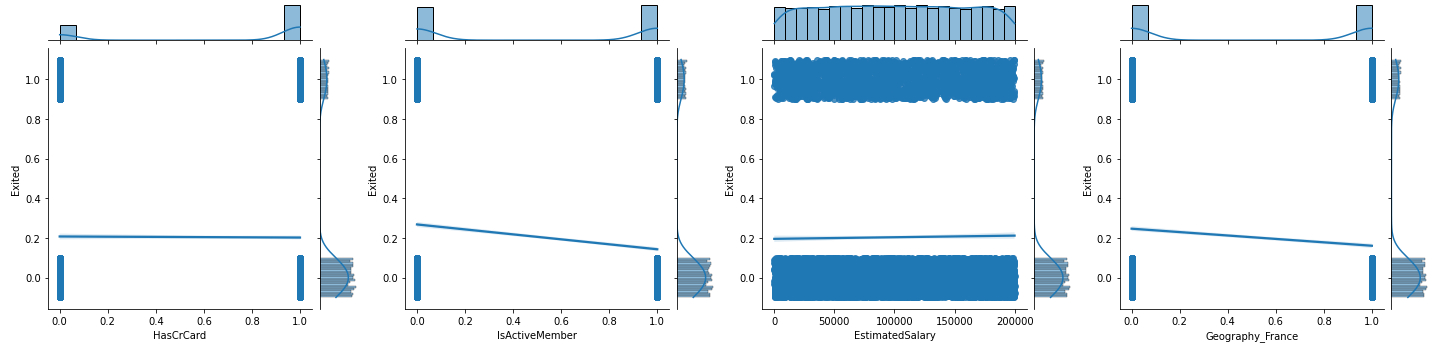

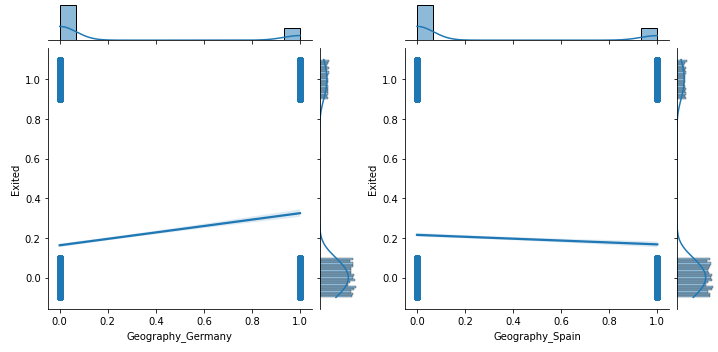

In [5]:
from libs.SeabornFig2Grid import SeabornFig2Grid
import matplotlib.gridspec as gridspec
#增強資料可視性
lst_tmp=[]
for i in range(len(df)):
  lst_tmp.append(random.uniform(-0.1,0.1))
df_plt=df.copy()
df_plt[TARGET]=df[TARGET]+lst_tmp
#繪製
for i in range(math.ceil(len(df_feature.columns)/4)):
  fig=plt.figure(figsize=(20,5))
  gs=gridspec.GridSpec(1, 4)
  for j in range(4):
    try:
      #fig_tmp=sns.kdeplot(data=df_plt, x=list(df_feature)[(4*i+j)])
      fig_tmp=sns.jointplot(x=list(df_feature)[(4*i+j)],y=TARGET,data=df_plt,kind='reg')
      mg=SeabornFig2Grid(fig_tmp, fig, gs[j])
    except IndexError:
      continue     
  gs.tight_layout(fig)
  plt.show()

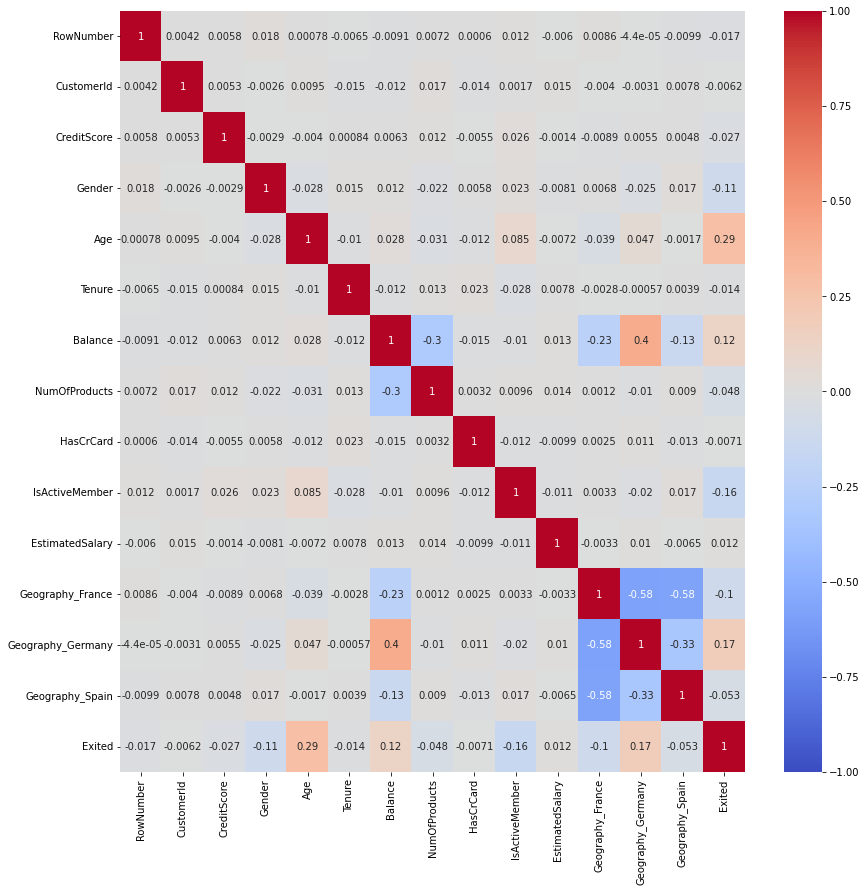

In [6]:
plt.figure(figsize=(14,14))
sns.heatmap(df.corr(), vmin=-1, cmap='coolwarm', annot=True)

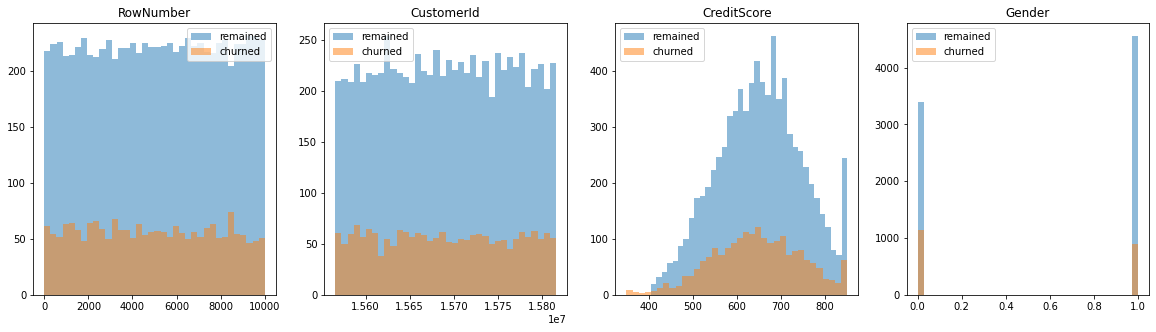

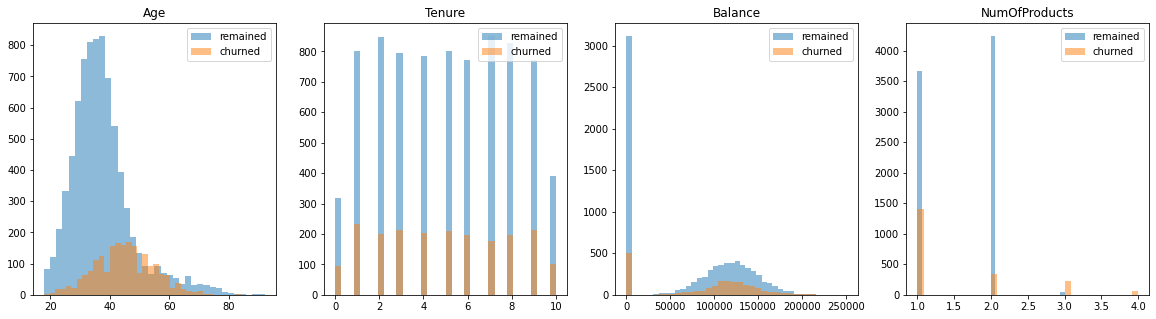

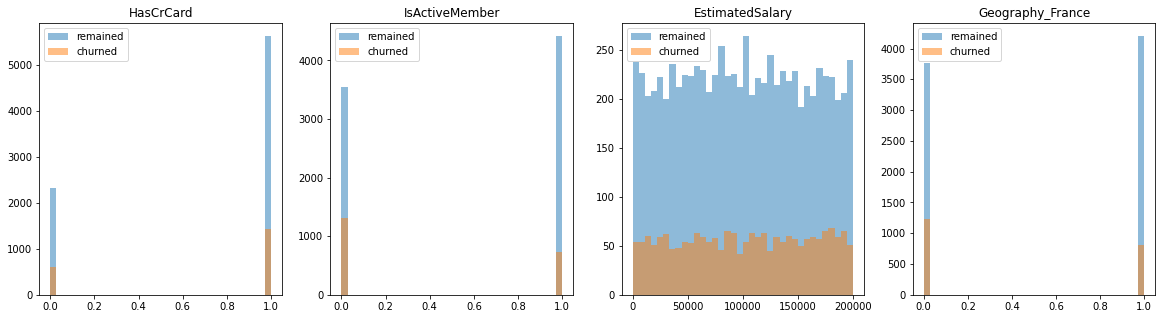

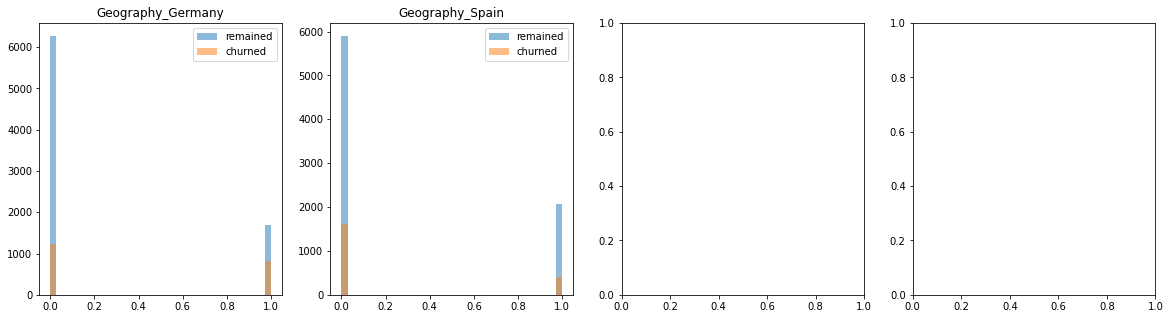

In [7]:
df_churned = df[df['Exited'] == 1]
df_remained = df[df['Exited'] == 0]

lst_df_columns = df_feature.columns
for i in range(math.ceil(len(lst_df_columns)/4)):
  fig=plt.figure(figsize=(20,5))
  for j in range(4):
    try:
      plt.subplot(1, 4, j+1)
      plt.hist(df_remained[lst_df_columns[4*i+j]],bins=36,alpha=0.5)
      plt.hist(df_churned[lst_df_columns[4*i+j]],bins=36,alpha=0.5)
      plt.title(lst_df_columns[4*i+j])
      plt.legend(['remained','churned'])
    except IndexError:
      continue     
  plt.show()

## Feature Select

In [8]:
df_mlp = df.drop(columns=['CustomerId','RowNumber'])
df_ = df[['Age','IsActiveMember','Geography_France','Geography_Germany','Exited']]

## Training Prepare

In [9]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
def training(df,method,scaler=None,fig_amount_show=100):
    # Training set & Testing set
    X = df[df.columns[:-1]].values
    Y = df[df.columns[-1]].values
    classifier = method
    if scaler=='minmax':
        sc = MinMaxScaler()
        sc.fit(X)
        X = sc.transform(X)
    elif scaler=='std':
        sc = StandardScaler()
        sc.fit(X)
        X = sc.transform(X)
    else:
        X = X
    train_X,test_X,train_Y,test_Y=train_test_split(X,Y,test_size=0.3, random_state=0)

    classifier.fit(train_X, train_Y)
    print(classifier.fit(train_X, train_Y))

    pred_Y = classifier.predict(test_X)
    test_prob=np.ravel(classifier.predict_proba(test_X)[:,[1]])
    df_pred = pd.DataFrame({'Actual': test_Y, 'Predicted': pred_Y,'Probability':test_prob}).round(3)
    df_pred['Error']=df_pred['Predicted']-df_pred['Actual']
    try:
      df_pred=df_pred.iloc[random.sample(df_pred.index.tolist(), fig_amount_show)] 
    except ValueError:
      print("Your data is smaller than fig_amount_show's setting. ")
    df_pred=df_pred.sort_values(by='Actual').reset_index(drop=True)   
    max_value=max([df_pred['Actual'].max(),df_pred['Predicted'].max()])
    
    #plot
    plt.figure(figsize=(25,3))
    plt.bar(df_pred.index,df_pred['Probability'],width=0.5,zorder=1)
    plt.bar(df_pred[df_pred['Error']!=0].index,df_pred[df_pred['Error']!=0]['Probability'],width=0.5,zorder=1,color='r')
    plt.scatter(df_pred.index,df_pred['Predicted'],c='r',s=12,zorder=3)
    plt.scatter(df_pred.index,df_pred['Actual'],zorder=2,c='g')
    plt.xticks(df_pred.index,df_pred['Probability'].round(3),rotation=90)
    plt.legend(['predict','actual','prob','Predict_error prob'])
    plt.grid() 
    plt.show()
    try:
      loss_values = classifier.loss_curve_
      plt.plot(loss_values)
      plt.show()
    except AttributeError:
      pass
    print('Train Score:', round(classifier.score(train_X,train_Y),4))
    print('Accuracy Score:', round(metrics.accuracy_score(test_Y,pred_Y,normalize=True),4))
    print('Confusion Matrix:', metrics.confusion_matrix(test_Y,pred_Y))

## Training

SVC(probability=True)


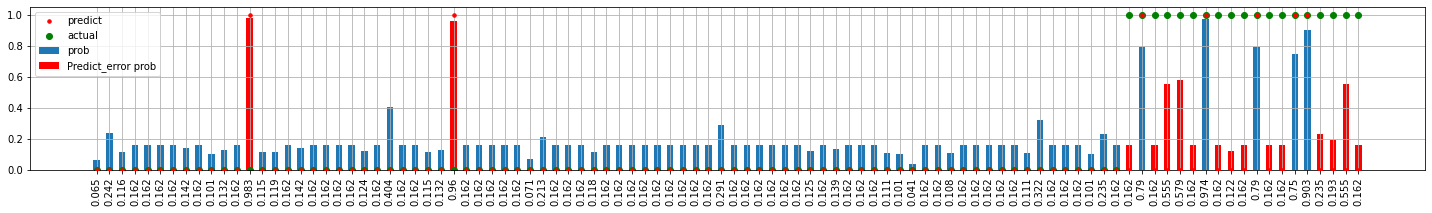

Train Score: 0.829
Accuracy Score: 0.8317
Confusion Matrix: [[2354   25]
 [ 480  141]]


In [10]:
from sklearn.svm import SVC
training(df_, SVC(probability=True),scaler='minmax')

LogisticRegression()


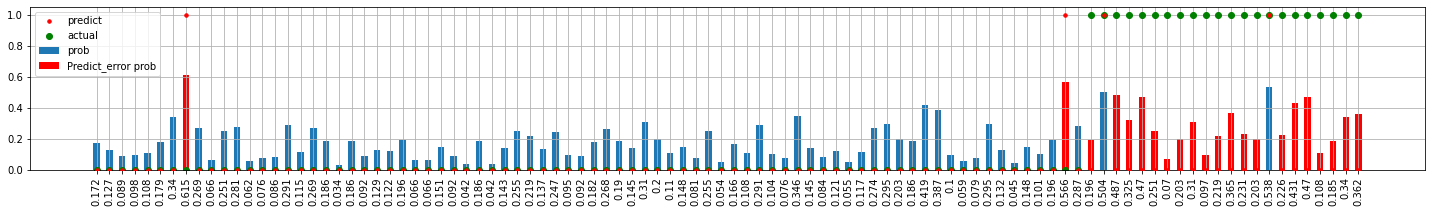

Train Score: 0.8124
Accuracy Score: 0.8143
Confusion Matrix: [[2318   61]
 [ 496  125]]


In [11]:
from sklearn.linear_model import LogisticRegression
training(df_, LogisticRegression(),scaler='minmax')

KNeighborsClassifier()


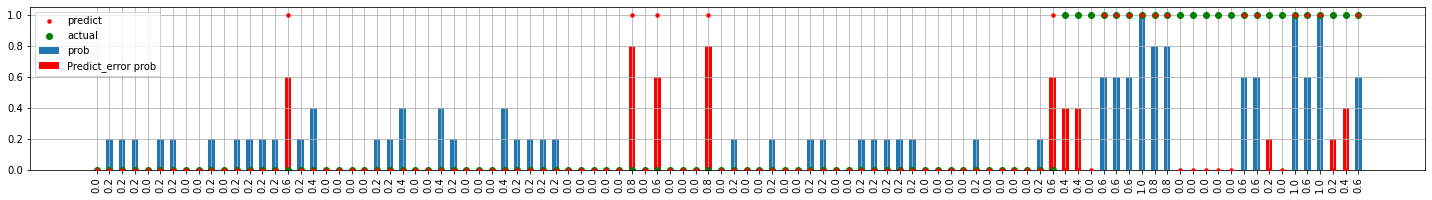

Train Score: 0.8087
Accuracy Score: 0.8057
Confusion Matrix: [[2130  249]
 [ 334  287]]


In [12]:
from sklearn.neighbors import KNeighborsClassifier
training(df_, KNeighborsClassifier(),scaler='minmax')

DecisionTreeClassifier()


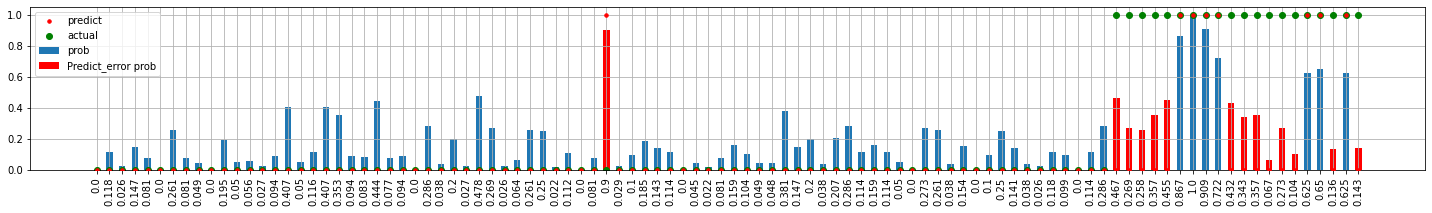

Train Score: 0.8384
Accuracy Score: 0.8373
Confusion Matrix: [[2320   59]
 [ 429  192]]


In [13]:
from sklearn.tree import DecisionTreeClassifier
training(df_, DecisionTreeClassifier())

RandomForestClassifier()


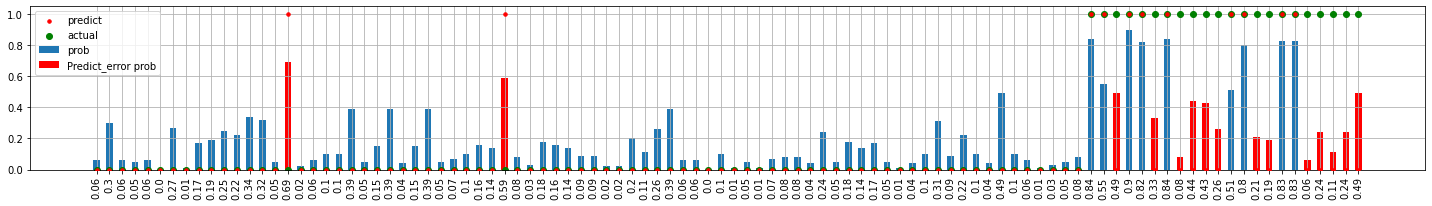

Train Score: 1.0
Accuracy Score: 0.8643
Confusion Matrix: [[2283   96]
 [ 311  310]]


In [14]:
from sklearn.ensemble import RandomForestClassifier
training(df_mlp, RandomForestClassifier())

SGDClassifier(loss='modified_huber')


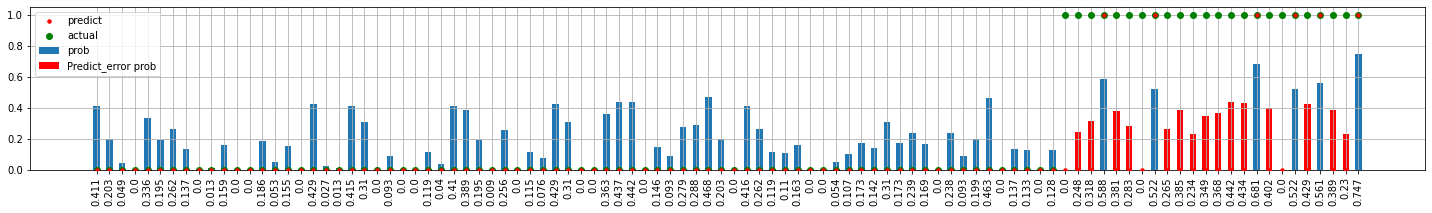

Train Score: 0.8099
Accuracy Score: 0.8127
Confusion Matrix: [[2328   51]
 [ 511  110]]


In [15]:
from sklearn.linear_model import SGDClassifier
training(df_, SGDClassifier(loss='modified_huber'),scaler='minmax')

MLPClassifier(hidden_layer_sizes=(8, 8, 8, 4, 2))


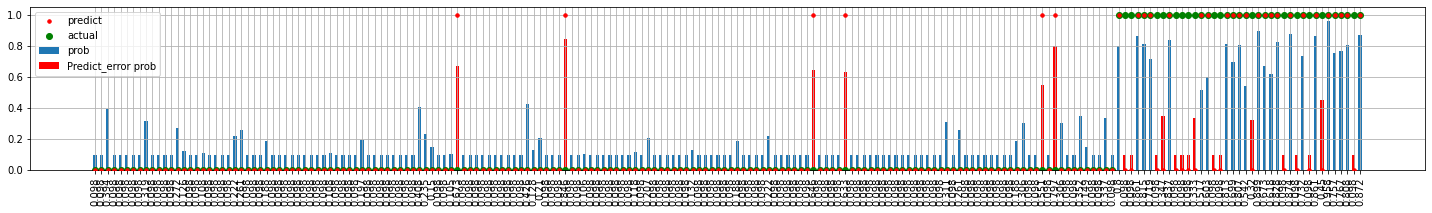

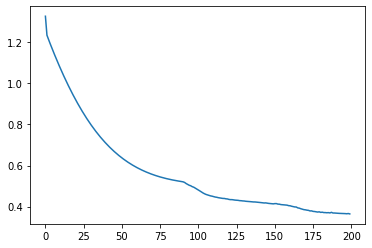

Train Score: 0.8623
Accuracy Score: 0.8593
Confusion Matrix: [[2265  114]
 [ 308  313]]


In [16]:
from sklearn.neural_network import MLPClassifier
training(df_mlp, MLPClassifier(hidden_layer_sizes=(8,8,8,4,2)), scaler='minmax',fig_amount_show=200)

## BOOSTING

AdaBoostClassifier(learning_rate=0.2, n_estimators=100)


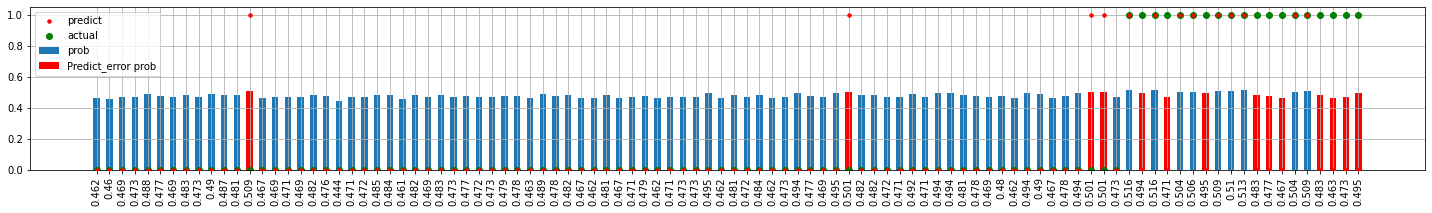

Train Score: 0.8291
Accuracy Score: 0.836
Confusion Matrix: [[2309   70]
 [ 422  199]]


In [17]:
from sklearn.ensemble import AdaBoostClassifier
training(df_, AdaBoostClassifier(n_estimators=100,learning_rate=0.2),scaler='minmax')

XGBClassifier()


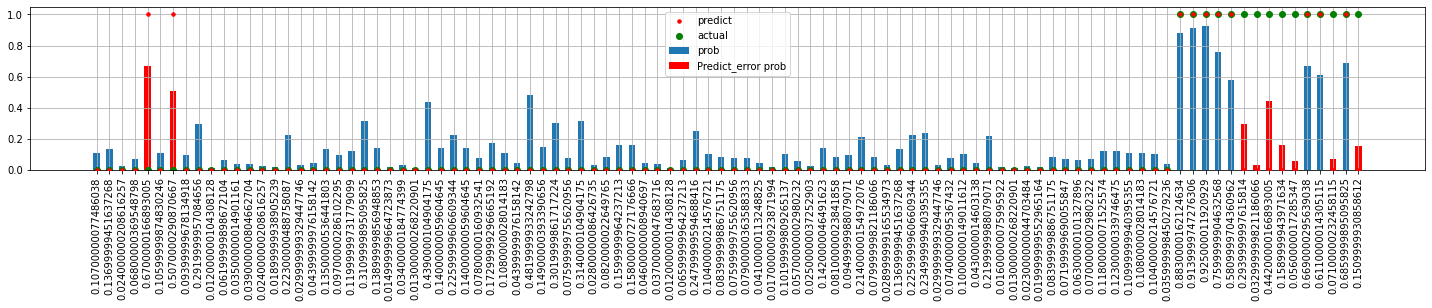

Train Score: 0.8699
Accuracy Score: 0.8697
Confusion Matrix: [[2292   87]
 [ 304  317]]


In [18]:
from xgboost.sklearn import XGBClassifier
training(df_mlp,XGBClassifier())

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


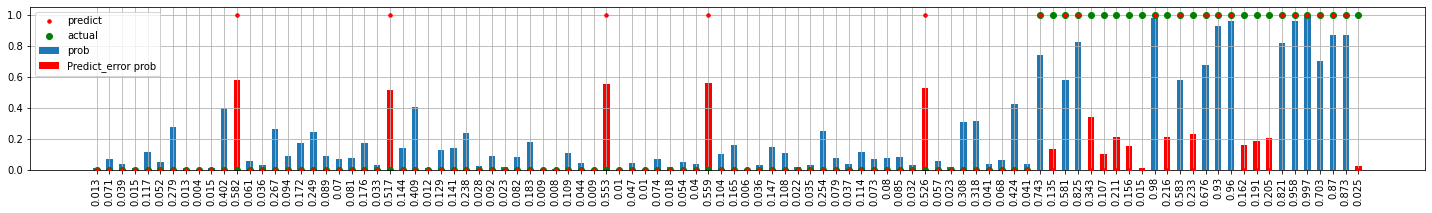

Train Score: 0.9106
Accuracy Score: 0.8667
Confusion Matrix: [[2271  108]
 [ 292  329]]


In [19]:
!pip install catboost
from catboost import CatBoostClassifier
training(df_mlp,CatBoostClassifier(verbose=False),scaler='minmax')

## Bagging

BaggingClassifier(base_estimator=XGBClassifier(), n_estimators=100)


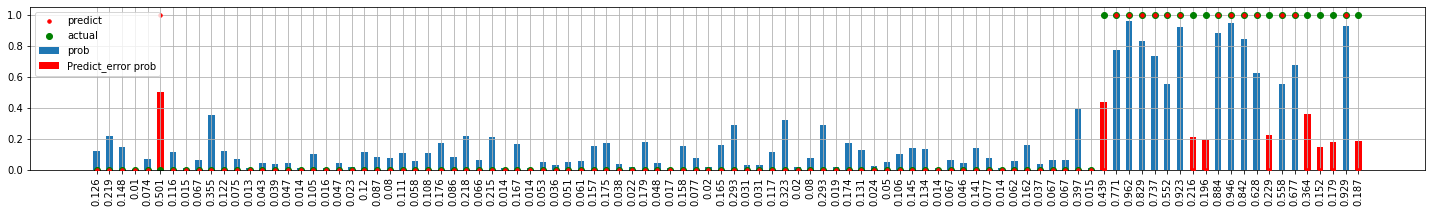

Train Score: 0.8713
Accuracy Score: 0.864
Confusion Matrix: [[2281   98]
 [ 310  311]]


In [20]:
from sklearn.ensemble import BaggingClassifier
from xgboost.sklearn import XGBClassifier
clf=XGBClassifier()
training(df_mlp,BaggingClassifier(base_estimator=clf,n_estimators=100))
